$s$: CARを計算できたPRの文書集合、$s_1 (\subset s)$: CARが高かったPRの文書集合、$s_2 (:= s - s_1)$: CARが高くなかったPRの文書集合とする。

単語$t$に対して、${\rm tf}\cdot{\rm idf}$値を以下のように定義。

$$
{\rm tf}(t, s_1) = \frac{df(t, s_1)}{|s_1|}
$$

$$
{\rm idf}(t) = \log\frac{|s|}{df(t,s)}
$$

$$
{\rm df}(t, x) = \left|\{d\mid d\ni t, d\in x\}\right|
$$

$$
{\rm tf}\cdot{\rm idf}(t, s_1) = {\rm tf}(t, s_1)\cdot {\rm idf}(t)
$$

${\rm df}(t, x)$は、全PR集合$s$のうち、単語$t$を含むPRの数。${\rm idf}(t)$は単語の出現頻度に依存した重みを与える。

${\rm idf}$の$\log$が無い場合はオッズ比のようなものになり(片方の群がもう片方を含んでいることに注意)、${\rm tf}\cdot{\rm idf}$の意味は次のようになる。

tf-idf ~ 0 <=> word w is enriched among s, the entire set 

tf-idf ~ 1 (or >> 0 if taking log) <=> word w is enriched only in s_1

In [18]:
## 入力データのファイル名
pr_mor_fname = "../fix_input_data/pressrelease_all_normalized.csv.mor"   # MeCab で形態素に分解済みの全プレスリリース本文
car_sig_fname = "car_exactT_alpha0.1_sig"   # 有意な CAR
car_not_sig_fname = "car_exactT_alpha0.1_not_sig"   # 有意でない CAR

In [2]:
## import
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
from scipy import stats
from multiprocessing import Pool
from collections import Counter

## データの読み込み

In [3]:
## CAR。tf-idf 計算は、car_sig と car_all = car_sig + car_not_sig の間で行う
## CAR が計算できたものだけを取り扱う点、PR ごとに CAR の平均値を取らない点(後述)が前回と異なる。

car_sig = pd.read_table(car_sig_fname, sep = '\t')   # 有意なもの
car_not_sig = pd.read_table(car_not_sig_fname, sep = '\t')   # 有意でないもの
car_sig[0:3]

,article_id,pr_type,comp_code,car,t_stat
0,NIKPRLRSP040809_18022003,01: Product,2593,0.079042,1.582459
1,NIKPRLRSP045017_21042003,04: Alliance,7599,0.120927,1.583770
2,NIKPRLRSP050445_10072003,01: Product,7911,0.104491,2.325275


In [4]:
id_set_sig = set(car_sig["article_id"])   # 一番上の s_1 (の ID)に対応する
id_set_not_sig = set(car_not_sig["article_id"])
id_set_all = id_set_sig.union(id_set_not_sig)   # s (の ID)に対応する

num_sig = len(id_set_sig)   # | s_1 | に対応する
num_all = len(id_set_all)   # | s | に対応する
print(num_sig, len(id_set_not_sig), len(id_set_sig.intersection(id_set_not_sig)), num_all)

706 24397 108 24995


-> 有意な CAR を持つ PR 706個のうち、108個が有意でない(他の企業とのマッチングによる) CAR も同時に持っている

TODO: これの扱い (現在は有意な PR に含めている; PR ごとに CAR の平均を取ること(前回はこれを採用していた)はしたくない)

In [19]:
## PR本文の分かち書き。pd.read_table は OutOuMemory で落ちてしまったので、1行ごとに追加する

pr_mor = pd.DataFrame()
with open(pr_mor_fname, 'r') as f:
    for line in f:
        article_id, mor = line.strip().split('\t')
        if article_id in id_set_all:
            pr_mor = pr_mor.append([[article_id, mor]], ignore_index = True)
pr_mor.columns = ["article_id", "pr_mor"]

## df, idf, tf, tf-idf の計算

### 有意なCARを持つPRと、CARが計算できた全てのPRの2群

In [20]:
pr_sig = pr_mor[[x in id_set_sig for x in list(pr_mor["article_id"])]]   # s_1 に含まれるプレスリリース
pr_all = pr_mor[[x in id_set_all for x in list(pr_mor["article_id"])]]   # s に含まれるプレスリリース

In [21]:
pr_as_word_set_sig = [set(x.split(' ')) for x in list(pr_sig["pr_mor"])]   # [set(words in PR in s_1)]
pr_as_word_set_all = [set(x.split(' ')) for x in list(pr_all["pr_mor"])]   # [set(words in PR in s)]

In [22]:
word_count = Counter()
for mor in list(pr_all["pr_mor"]):
    for w in mor.split(' '):
        word_count[w] += 1
        
## TODO: 単語の純粋な出現回数ではなく、出現したPRの数でフィルターするべき？

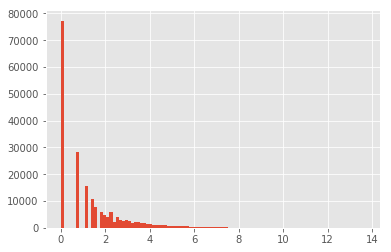

In [23]:
ret = plt.hist(list(map(math.log, list(word_count.values()))), bins = 100)   # 対数プロット

In [24]:
## 全PR中での単語の出現回数でフィルタリング
max_count = 1000000
min_count = 0

words = set()   # filtered set of words to be used for tf-idf calculation
for w, c in word_count.items():
    if min_count <= c and c <= max_count:
        words.add(w)

In [11]:
def calc_pr_num_with_word_in_sig(word):   # s1 のうち word を含む PR の数
    count = 0
    for mor in pr_as_word_set_sig:
        if word in mor:
            count += 1
    return (word, count)

def calc_pr_num_with_word_in_all(word):   # s のうち word を含む PR の数
    count = 0
    for mor in pr_as_word_set_all:
        if word in mor:
            count += 1
    return (word, count)

In [25]:
with Pool(7) as exe_pool:
    df_sig = Counter()
    for ret in exe_pool.imap(calc_pr_num_with_word_in_sig, words):
        df_sig[ret[0]] = ret[1]

In [26]:
list(df_sig.items())[0:10]

[('SBM', 1),
 ('桜の樹の下で', 0),
 ('ズコンフォートメンバーズ', 0),
 ('アイエヌジースマートデザイン', 0),
 ('サイトウキネンフェスティバル', 0),
 ('ュパ', 0),
 ('直久', 0),
 ('イミダフェナシン', 0),
 ('森林公園', 0),
 ('nga', 0)]

In [27]:
with Pool(7) as exe_pool:
    df_all = Counter()
    for ret in exe_pool.imap(calc_pr_num_with_word_in_all, words):
        df_all[ret[0]] = ret[1]

In [28]:
list(df_all.items())[0:10]

[('SBM', 6),
 ('桜の樹の下で', 1),
 ('ズコンフォートメンバーズ', 2),
 ('アイエヌジースマートデザイン', 2),
 ('サイトウキネンフェスティバル', 1),
 ('ュパ', 1),
 ('直久', 1),
 ('イミダフェナシン', 3),
 ('森林公園', 2),
 ('nga', 1)]

In [ ]:
def calc_tfidf(w):
    tfidf_value = float(df_sig[w]) / num_sig * math.log(float(num_all) / df_all[w], 2)
    return (w, tfidf_value, df_all[w], num_all - df_all[w], df_sig[w], num_sig - df_sig[w])

In [34]:
tfidf = pd.DataFrame()
with Pool(7) as exe_pool:
    for ret in exe_pool.imap(calc_tfidf, words):
        tfidf = tfidf.append([[*ret]], ignore_index = True)
tfidf.columns = ["word", "tf-idf", "df_all", "num_all - df_all", "df_sig", "num_sig - df_sig"]
tfidf = tfidf.sort_values('tf-idf', ascending = False)

In [35]:
tfidf[0:10]
## 検定は odds_ratio, p_value = stats.fisher_exact(count_table) で行う。全部の検定は時間がかかるのでここでは行わず、後でトップの単語から順に調べる

,word,tf-idf,df_all,num_all - df_all,df_sig,num_sig - df_sig
65661,2008年,0.697310,5187,19808,217,489
146728,まいり,0.621902,7033,17962,240,466
3220,なる,0.598459,9262,15733,295,411
182957,本,0.587867,7688,17307,244,462
54063,において,0.586174,8940,16055,279,427
101666,化,0.583141,9151,15844,284,422
78567,代表取締役社長,0.582344,10837,14158,341,365
76401,拡大,0.582086,6016,18979,200,506
116614,および,0.580079,9328,15667,288,418
151515,利用,0.576588,9573,15422,294,412


In [79]:
def has_element_less_than(table, min_n = 10):
    for row in table:
        for element in row:
            if element < min_n:
                return True
    return False

def has_zero(table):
    return has_element_less_than(table, min_n = 1)

def test_frequency(data):
    df_all = data["df_all"]
    not_df_all = data["num_all - df_all"]
    df_sig = data["df_sig"]
    not_df_sig = data["num_sig - df_sig"]
    
    table  =[[df_all - df_sig, not_df_all - not_df_sig], [df_sig, not_df_sig]]   # all - sig をしていることに注意、これで有意な群と有意でない群に分かれた
    
    if has_zero(table):
        pvalue = stats.fisher_exact(table)[1]
    else:
        x2, pvalue, dof, expected = stats.chi2_contingency(table)
        if has_element_less_than(expected):
            pvalue = stats.fisher_exact(table)[1]
    return pvalue

In [80]:
tfidf_with_pvalue = tfidf.copy()
tfidf_with_pvalue["p_value"] = tfidf_with_pvalue.apply(test_frequency, axis = 1)
tfidf_with_pvalue = tfidf_with_pvalue.sort_values('p_value', ascending = True)

In [83]:
tfidf_with_pvalue[tfidf_with_pvalue["tf-idf"] >= 0.1]

,word,tf-idf,df_all,num_all - df_all,df_sig,num_sig - df_sig,p_value
65661,2008年,0.697310,5187,19808,217,489,4.423709e-11
62990,2009年,0.294426,4952,20043,89,617,1.400294e-06
142557,10月30日,0.157222,148,24847,15,691,2.043686e-05
190217,施策,0.244835,524,24471,31,675,2.867996e-05
13620,添付,0.332284,5155,19840,103,603,7.092913e-05
124128,ベビー,0.108908,67,24928,9,697,1.076507e-04
156635,−,0.172016,2256,22739,35,671,1.697952e-04
139764,2005年,0.568501,4249,20746,157,549,2.087089e-04
37582,号,0.263127,699,24296,36,670,2.637223e-04
84158,比率,0.223482,503,24492,28,678,3.015775e-04


### 有意なCARを値でさらに2群に分ける

In [93]:
car_sig_all = pd.read_table(car_sig_fname, sep = '\t')   # 有意なもの全部

car_threshold = np.median(car_sig_all["car"])   # 中央値で分割
car_sig_1 = car_sig_all[car_sig_all["car"] >= car_threshold]
car_not_sig_1 = car_sig_all[car_sig_all["car"] < car_threshold]

id_set_sig_all = set(car_sig_all["article_id"])
id_set_sig_1 = set(car_sig_1["article_id"])
id_set_not_sig_1 = set(car_not_sig_1["article_id"])

num_sig_all = len(id_set_sig_all)   # | s | に対応する
num_sig_1 = len(id_set_sig_1)   # | s_1 | に対応する
#num_sig_2 = len(id_set_sig_all)

In [94]:
print(num_sig_1, len(id_set_not_sig_1), len(id_set_sig_1.intersection(id_set_not_sig_1)), num_sig_all)

354 354 2 706


-> 2つのPRだけ、高い有意なCARと低い有意なCARの2つを同時に持っていた。上の例と同様にこれは高い方に含めているが、数が少ないため影響は少ないから大丈夫か。

In [96]:
pr_sig_1 = pr_mor[[x in id_set_sig_1 for x in list(pr_mor["article_id"])]]   # s_1 に含まれるプレスリリース
pr_sig_all = pr_mor[[x in id_set_sig_all for x in list(pr_mor["article_id"])]]   # s に含まれるプレスリリース

In [97]:
pr_as_word_set_sig_1 = [set(x.split(' ')) for x in list(pr_sig_1["pr_mor"])]   # [set(words in PR in s_1)]
pr_as_word_set_sig_all = [set(x.split(' ')) for x in list(pr_sig_all["pr_mor"])]   # [set(words in PR in s)]

In [98]:
word_count = Counter()
for mor in list(pr_sig_all["pr_mor"]):
    for w in mor.split(' '):
        word_count[w] += 1
        
## TODO: 単語の純粋な出現回数ではなく、出現したPRの数でフィルターするべき？

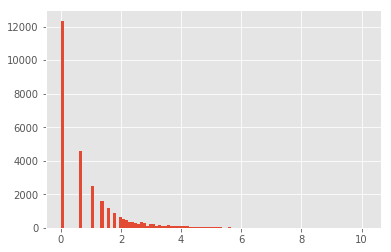

In [99]:
ret = plt.hist(list(map(math.log, list(word_count.values()))), bins = 100)   # 対数プロット

In [100]:
## 全PR中での単語の出現回数でフィルタリング
max_count = 1000000
min_count = 0

words = set()   # filtered set of words to be used for tf-idf calculation
for w, c in word_count.items():
    if min_count <= c and c <= max_count:
        words.add(w)

In [103]:
def calc_pr_num_with_word_in_sig(word):   # s1 のうち word を含む PR の数
    count = 0
    for mor in pr_as_word_set_sig_1:
        if word in mor:
            count += 1
    return (word, count)

def calc_pr_num_with_word_in_all(word):   # s のうち word を含む PR の数
    count = 0
    for mor in pr_as_word_set_sig_all:
        if word in mor:
            count += 1
    return (word, count)

In [104]:
with Pool(7) as exe_pool:
    df_sig_1 = Counter()
    for ret in exe_pool.imap(calc_pr_num_with_word_in_sig, words):
        df_sig_1[ret[0]] = ret[1]

In [105]:
with Pool(7) as exe_pool:
    df_sig_all = Counter()
    for ret in exe_pool.imap(calc_pr_num_with_word_in_all, words):
        df_sig_all[ret[0]] = ret[1]

In [107]:
def calc_tfidf(w):
    tfidf_value = float(df_sig_1[w]) / num_sig_1 * math.log(float(num_sig_all) / df_sig_all[w], 2)
    return (w, tfidf_value, df_sig_all[w], num_sig_all - df_sig_all[w], df_sig_1[w], num_sig_1 - df_sig_1[w])

In [108]:
tfidf_sig = pd.DataFrame()
with Pool(7) as exe_pool:
    for ret in exe_pool.imap(calc_tfidf, words):
        tfidf_sig = tfidf_sig.append([[*ret]], ignore_index = True)
tfidf_sig.columns = ["word", "tf-idf", "df_all", "num_all - df_all", "df_sig", "num_sig - df_sig"]
tfidf_sig = tfidf_sig.sort_values('tf-idf', ascending = False)

In [109]:
tfidf_sig_with_pvalue = tfidf_sig.copy()
tfidf_sig_with_pvalue["p_value"] = tfidf_sig_with_pvalue.apply(test_frequency, axis = 1)
tfidf_sig_with_pvalue = tfidf_sig_with_pvalue.sort_values('p_value', ascending = True)

In [110]:
tfidf_sig_with_pvalue

,word,tf-idf,df_all,num_all - df_all,df_sig,num_sig - df_sig,p_value
6805,2009年,0.641447,89,617,76,278,2.533112e-12
2554,−,0.391796,35,671,32,322,1.314436e-06
21989,2005年,0.330850,157,549,54,300,1.162804e-05
5933,パソコン,0.432655,53,653,41,313,6.958366e-05
2331,東京都港区,0.631477,177,529,112,242,7.788312e-05
18880,インターネット,0.546798,101,605,69,285,1.236047e-04
9616,孫正義,0.325250,29,677,25,329,1.586946e-04
8339,2008年,0.634634,217,489,132,222,2.139189e-04
25375,森永製菓株式会社,0.000000,11,695,0,354,4.370954e-04
9545,ソフトバンクモバイル株式会社,0.250467,19,687,17,337,6.245977e-04
